In [2]:
import numpy as np
from numpy import linalg as LA

#https://pyscf.org
import pyscf
from pyscf import gto
from pyscf import scf

import matplotlib.pyplot as plt
import seaborn as sns

In this Jupyter notebook we will investigate the Hartree-Fock (HF) method. We want to use it to determine the HF energy for a water (H$_2$O) molecule. First we have to define our chemical system by the atoms and their coordinates. Additionally, we have to specify in which basis set we want to use.

In [21]:
#define a molecule by coordinates and basis set
mol = gto.Mole()

#geometry in bohr units
mol.unit = 'Bohr'
mol.atom = '''O 0.  0.     0.2404; 
              H 0.  1.4326 0.9611;
              H 0. -1.4326 0.9611'''
#input format for each atom: atom/nuclear charge x coordinate y coordinate z coordinate

#basis
mol.basis = 'sto-3g'
#other option here are e.g.: '3-21G', '6-31G', 'cc-pvdz', ...

mol.build()
print("Defined molecule: ")
print(mol._atom)
#print(mol._basis)

Defined molecule: 
[('O', [0.0, 0.0, 0.2404]), ('H', [0.0, 1.4326, 0.9611]), ('H', [0.0, -1.4326, 0.9611])]


In [15]:
# Alternatively, the basis functions can also be specified in terms of the exponents and coefficients of the GTOs.
# This is the STO-3G basis of H and O (see also https://www.basissetexchange.org/)
mol.basis = {'H': gto.basis.parse('''
H    S
      0.3425250914E+01       0.1543289673E+00
      0.6239137298E+00       0.5353281423E+00
      0.1688554040E+00       0.4446345422E+00
''')}
mol.basis = {'O': gto.basis.parse('''
O    S
      0.1307093214E+03       0.1543289673E+00
      0.2380886605E+02       0.5353281423E+00
      0.6443608313E+01       0.4446345422E+00
O    P
      0.5033151319E+01      -0.9996722919E-01       0.1559162750E+00
      0.1169596125E+01       0.3995128261E+00       0.6076837186E+00
      0.3803889600E+00       0.7001154689E+00       0.3919573931E+00
''')}
#print(mol.basis)

Now we can take a closer look at our defined chemical system. \
Since we use restricted Hartee-Fock in the following (assuming all molecular orbitals are fully occupied), there should also be an even number of electrons in the system. It is also easy to determine the number of occupied orbitals.

In [16]:
#number of electrons
print(mol.nelectron, "electrons")

Nocc =  int(mol.nelectron/2)
print(Nocc, "occupied orbitals")

#print(mol.nbas)

Nao = mol.nao_nr()
print(Nao, "atomic orbitals, for which the optimal coefficients shall be found")

print(mol.npgto_nr(), "primitive GTOs")

10 electrons
5 occupied orbitals
7 atomic orbitals, for which the optimal coefficients shall be found
21 primitive GTOs


### <span style="color:orange">Roothaan-Hall equations</span> ###

In principle, we assume the following eigenequation (Roothaan-Hall):           

$$ F \; C = S \; C \; \varepsilon $$

where $F$ is the Fock matrix, $C$ is a coefficient matrix, and $\varepsilon$ is the diagonal matrix with the orbital energies. However, this equation does not yet show that it is an eigenvalue equation. Therefore we multiply from the left by $S^{-\frac{1}{2}}$ and get

$$ S^{-\frac{1}{2}} \; F \; C = S^{-\frac{1}{2}} \; S \; C \; \varepsilon = S^{+ \frac{1}{2}} \; C \; \varepsilon$$

Now, between the Fock matrix $F$ and the coefficient matrix $C$, we add the unit matrix in the form of $S^{-\frac{1}{2}} S^{+ \frac{1}{2}}$ a

$$ S^{-\frac{1}{2}} \; F \; \Bigl( S^{-\frac{1}{2}} S^{+ \frac{1}{2}} \Bigl) \; C = S^{+ \frac{1}{2}} \; C \; \varepsilon$$
   
$$ \Bigl( S^{-\frac{1}{2}} \; F \; S^{-\frac{1}{2}} \Bigl) \; \; \Bigl( S^{+ \frac{1}{2}} \; C \Bigl) = \Bigl( S^{+ \frac{1}{2}} \; C \Bigl) \; \varepsilon $$

$$ F^\prime \; C^\prime = C^\prime \; \varepsilon $$

      
Now this corresponds to an eigenequation. So we need to transform $S$ into $S^{-\frac{1}{2}}$.
To do this, we calculate the eigenvalues and eigenvectors of this matrix. In fact, it is easy to take the square root of the eigenvalues. In principle, you should be able to calculate this with paper and pencil, but what do we have numpy for?

In [17]:
#calculate the overlap matrix of S and S^-1/2 (S_msqrt)
S = mol.intor('int1e_ovlp')
print("overlap matrix:")
print(S)

S_diag, v = LA.eig(S)
S_temp = 1/np.sqrt(S_diag)
S_msqrt = v @ np.diag(S_temp) @ v.transpose()

overlap matrix:
[[ 1.00000000e+00  2.36703937e-01  4.96725580e-18  0.00000000e+00
  -8.99787606e-18  6.93813768e-02  6.93813768e-02]
 [ 2.36703937e-01  1.00000000e+00  0.00000000e+00  0.00000000e+00
   6.41255300e-17  5.47320826e-01  5.47320826e-01]
 [ 4.96725580e-18  0.00000000e+00  1.00000000e+00  0.00000000e+00
   0.00000000e+00 -2.66003211e-02 -2.66003211e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
   0.00000000e+00  3.81076199e-01 -3.81076199e-01]
 [-8.99787606e-18  6.41255300e-17  0.00000000e+00  0.00000000e+00
   1.00000000e+00  1.91708514e-01  1.91708514e-01]
 [ 6.93813768e-02  5.47320826e-01 -2.66003211e-02  3.81076199e-01
   1.91708514e-01  1.00000000e+00  2.50886533e-01]
 [ 6.93813768e-02  5.47320826e-01 -2.66003211e-02 -3.81076199e-01
   1.91708514e-01  2.50886533e-01  1.00000000e+00]]


### <span style="color:orange">The Fock matrix</span> ###

In order to solve the Roothaan-Hall equation, the Fock matrix is needed. Let us now consider this for **closed-shell** **restricted** Hartree-Fock. Each element $F_{\mu\nu}$ of this can be written as.

$$ F_{\mu\nu} = \int \phi_\mu^*(1) \hat{f}(1) \phi_\nu(1) d\textbf{r}_1$$

where $\phi_\mu$ and $\phi_\nu$ are the building blocks of the molecular orbitals $\chi_i$ by the LCAO ("linear combination of atomic orbitals") approach with coefficients $C_{\mu i}$ weighted (with N electrons):

$$ \chi_i = \sum^{\frac{N}{2}}_{i} C_{\mu i} \phi_\mu$$

The Fock operator $\hat{f}$, which is in the Fock matrix elements, is composed of a 1-electron operator and the 2-electron operators, so that in total

$$ F_{\mu\nu} = \underbrace{\int \phi_{\mu}^\ast (1) \hat{h}(1) \phi_{\nu}(1) \; d\textbf{r}_1 }_{\substack{H^{\rm core}_{\mu\nu}}} + \sum^{\frac{N}{2}}_{i} \int \phi_\mu^\ast(1) \Bigl[ 2\hat{J}_i(1) - \hat{K}_i(1)\Bigl] \phi_\nu(1) \; d\textbf{r}_1   $$

Thus, $H^{\rm core}$ describes the interaction of the electron with all nuclei ($V^{en}$) on one side and additionally contains the kinetic energy $T$:

$$ H^{\rm core} = T + V^{\rm en}$$

$$ T_{\mu\nu} = \int \phi_\mu^*(1) \Bigl(-\frac{1}{2} \nabla^2 \Bigl) \phi_\nu(1) \; d\textbf{r}_1 $$

$$ V^{\rm en}_{\mu\nu} = \sum_{A} \int \phi_\mu^*(1) \Bigl(-\frac{Z_A}{r_{1A}} \Bigl) \phi_\nu(1) \; d\textbf{r}_1 $$


The 2-electron contributions can now also be rewritten using the LCAO approach. For the Coulomb part 

$$ \hat{J}_i(1) = \int \chi_i^*(2) \frac{1}{r_{12}} \chi_i(2) \; d\textbf{r}_2 = \sum_{\lambda} \sum_{\sigma} C^*_{\lambda i} C_{\sigma i} \int \phi_\lambda^*(2) \frac{1}{r_{12}} \phi_\sigma(2) \; d\textbf{r}_2$$

$$ \int \phi_\mu^*(1) \hat{J}_i(1) \phi_\nu(1) \; d\textbf{r}_1
= \sum_{\lambda} \sum_{\sigma} C^*_{\lambda i} C_{\sigma i} 
\underbrace{\int \int \phi_\mu^*(1) \phi_\lambda^*(2) \frac{1}{r_{12}} \phi_\nu(1) \phi_\sigma(2) \; d\textbf{r}_1 \; d\textbf{r}_2}_{\substack{(\mu \nu | \lambda \sigma)}}$$

The exchange contribution is analogous
$$ \int \phi_\mu^*(1) \hat{K}_i(1) \phi_\nu(1) \; d\textbf{r}_1
= \sum_{\lambda} \sum_{\sigma} C^*_{\lambda i} C_{\sigma i} (\mu \sigma | \lambda \nu) $$
where we use here a simplified notation for the 2-electron integrals.

In addition, the coefficients can be summarized to the so-called single-particle density matrix ("density matrix") D:
$$ D_{\mu\nu} = 2 \sum\limits_{i}^{\frac{N}{2}} C^*_{\mu i} C_{\nu i} $$

Thus, the elements of the Fock matrix can be written in simplified form as follows.
$$ F_{\mu\nu} = H^{\rm core}_{\mu\nu} + \sum_{\lambda} \sum_{\sigma} D_{\lambda\sigma} \Bigl( (\mu \nu | \lambda \sigma) - \frac{1}{2} (\mu \sigma | \lambda \nu) \Bigl) $$

For the integrals that are in the Fock matrix, we use functions from the Python PySCF module here, which take into account the information about atomic coordinates and basis set given above. We also add the contribution of the kinetic energy of the atoms $T$ and the electron-nucleus interactions $V^{\rm en}$ to get $H^{\rm core}$.

In [18]:
#build H_core matrix
T_e = mol.intor('int1e_kin')
V_en = mol.intor('int1e_nuc')
H_core = T_e + V_en
print("T:")
print(T_e)
print("V_en:")
print(V_en)
print("H_core:")
print(H_core)
#check printing

#obtain 2-electron integrals
int2e = mol.intor('int2e')

T:
[[ 2.90031999e+01 -1.68010939e-01  2.45857853e-17  0.00000000e+00
  -9.01930333e-17  7.47000094e-03  7.47000094e-03]
 [-1.68010939e-01  8.08127955e-01  0.00000000e+00  0.00000000e+00
   7.67503180e-17  1.86541721e-01  1.86541721e-01]
 [-3.94283162e-17  0.00000000e+00  2.52873120e+00  0.00000000e+00
   0.00000000e+00 -2.31918763e-02 -2.31918763e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  2.52873120e+00
   0.00000000e+00  3.32246820e-01 -3.32246820e-01]
 [-3.20279746e-16  5.20872739e-17  0.00000000e+00  0.00000000e+00
   2.52873120e+00  1.67143853e-01  1.67143853e-01]
 [ 7.47000094e-03  1.86541721e-01 -2.31918763e-02  3.32246820e-01
   1.67143853e-01  7.60031884e-01  8.29915126e-03]
 [ 7.47000094e-03  1.86541721e-01 -2.31918763e-02 -3.32246820e-01
   1.67143853e-01  8.29915126e-03  7.60031884e-01]]
V_en:
[[-6.18631781e+01 -7.47771033e+00  2.44879881e-03  0.00000000e+00
  -1.76484930e-02 -2.26442228e+00 -2.26442228e+00]
 [-7.47771033e+00 -1.02649761e+01  2.73501661e-02  0.0

### <span style="color:orange">The SCF method</span> ###

By the Self-Consistent-Field method we now want to find the corresponding coefficients for the orbitals. We obtain these by solving the Roothaan-Hall equation. However, since these coefficients are themselves in the Fock matrix, we have to proceed iteratively.

We now have everything we need to get started. 
As starting point we choose $F = H^{core}$, i.e. there is no stabilization of the molecule by the electrons. This corresponds to a zero matrix as the coefficient matrix.
We now proceed according to the following scheme:

1. with $S^{-\frac{1}{2}}$, $F$ is transformed into $F^\prime$.

2. now the eigenvectors $C^\prime$ and eigenvalues $\varepsilon$ of the above eigenequation are determined.

3. from $C^\prime$ we calculate $C$. These coefficients indicate the participation of the $\phi_{\mu}$ in the desired molecular orbitals $\chi_i$ and thus in the sought wave function. From them we calculate the density matrix $D$.

4. using this density matrix $D$, we calculate the Fock matrix.

From the Fock matrix the HF energy is calculated. To the electronic energy the core-nucleus repulsion $V_{\rm nn}$ is added to get the total energy.

$$ E^{\rm HF}_{\rm el} = \frac{1}{2} \sum_{\mu} \sum_{\nu} D_{\mu\nu} (H^{\rm core}_{\mu\nu} + F_{\mu\nu}) $$
$$ E^{\rm HF} = E^{\rm HF}_{\rm el} + V_{\rm nn} $$

6. check the desired convergence. If it is insufficient, we start again from step 1.
  We can check convergence, for example, by looking at the change in the energy obtained from step to step (that's how we do it here) or by looking at the change in the coefficients from step to step.

Now we execute the SCF procedure as explained. Here we can specify how many iteration cycles we want to allow ('max_it', here 20) and from which change of energy to the previous step we are satisfied with the convergence ('thresh', here 10$^{-8}$).

Iteration 0
coefficient matrix C:


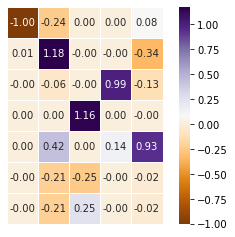

Energy in iteration 0 : -73.17747598824134 Hartree
Iteration 1
coefficient matrix C:


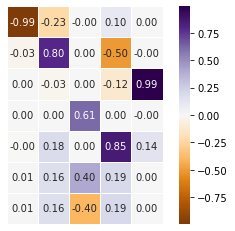

Energy in iteration 1 : -74.8930115226837 Hartree
Iteration 2
coefficient matrix C:


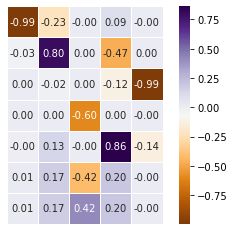

Energy in iteration 2 : -74.89451619991421 Hartree
Iteration 3
coefficient matrix C:


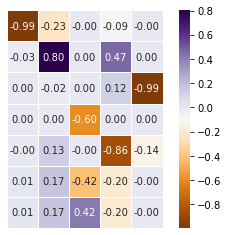

Energy in iteration 3 : -74.89454177628068 Hartree
Iteration 4
coefficient matrix C:


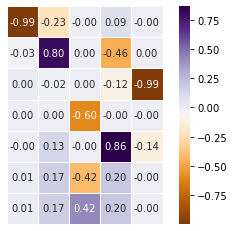

Energy in iteration 4 : -74.8945460098912 Hartree
Iteration 5
coefficient matrix C:


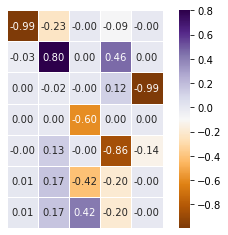

Energy in iteration 5 : -74.89454674048517 Hartree
Iteration 6
coefficient matrix C:


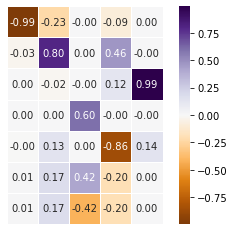

Energy in iteration 6 : -74.89454686796941 Hartree
Iteration 7
coefficient matrix C:


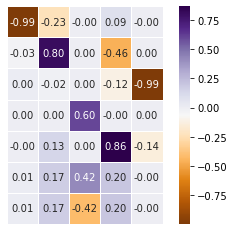

Energy in iteration 7 : -74.89454689029603 Hartree
Iteration 8
coefficient matrix C:


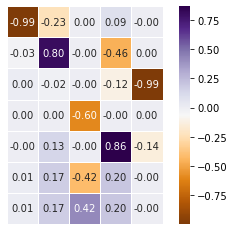

Energy in iteration 8 : -74.89454689421089 Hartree
*** SCF is converged! E_HF = -74.89454689421089 Hartree ***


In [19]:
#Form an estimated Start-Fock matrix
#Here we use only H_core for this, which corresponds to a zero matrix as coefficient matrix
F = np.copy(H_core)

#maximum number of allowed iterations
max_it = 20
thresh = 1e-8

#SCF cycle
for it in range(max_it):
    print("Iteration", it)
    
    ###solve Roothaan Hall equation
    #1. F' = S^-1/2 * F * S^-1/2
    F_ = S_msqrt @ F @ S_msqrt
    #2. C' by solving the eigenvalue problem
    eig, C_ = LA.eigh(F_)
    #3. C = S^-1/2 * C_
    C = S_msqrt @ C_    
    # by coefficient matrix over all occupied orbitals
    C_mui =  C[:,:Nocc]
    D = 2* C_mui @ C_mui.transpose()
    
    print("coefficient matrix C:")
    ax = sns.heatmap(C_mui, linewidth=0.5, cmap="PuOr", square=True, annot=True, fmt=".2f", xticklabels = False, yticklabels = False)
    plt.show()
    
    ##4. calculate new Fock matrix
    for i in range(Nao):
        for j in range(Nao):
            temp_2el = 0
            for k in range(Nao):
                for l in range(Nao):
                    temp_2el += D[k,l] * (int2e[i,j,k,l] - 0.5 * int2e[i,l,k,j])
            F[i,j] = H_core[i,j] + temp_2el
    
    #5. calculate energy
    E = 0
    for i in range(Nao):
        for j in range(Nao):
            E += D[i,j] * (H_core[i,j] + F[i,j])
    #add Vnn 
    E = 0.5 * E + mol.energy_nuc()
    print("Energy in iteration", it,":", E, "Hartree")

    #6. stopping criterion
    if (it == 0):
        E_prev = np.copy(E)
    elif (np.abs(E-E_prev) <= thresh):
        print("*** SCF is converged! E_HF = {} Hartree ***".format(E))
        break
    else:
        E_prev = np.copy(E)

The Python module PySCF, which we used to obtain the required integrals, even has a built-in SCF function. This can be used to compare our values obtained above. In the following cell we show how to call it.

However, since we do not have write permissions here via Moodle, we unfortunately get an error message.

The result we would otherwise get is: "converged SCF energy = -74.892584156952" (in Hartree).

In [ ]:
###Comparison with HF energy from PySCF function
#print("Energy for comparison:")
#mf = scf.RHF(mol)
#print(mf.kernel())

### <span style="color:orange">Koopman's theorem</span> ###

According to Koopman's theorem, the ionization potentials (IP) and electron affinities (EA) can be estimated from the orbital energies $\varepsilon$ obtained by the SCF method.

$ {\rm IP} = -\varepsilon_i $ for an occupied orbital $\chi_i$.

$ {\rm EA} = -\varepsilon_r $ for an unoccupied orbital $\chi_r$.

In [20]:
#Koopmann's theorem
#IP = -epsilon_Nocc
IP = -eig[Nocc-1]
print("The ionization potential for the removal of an electron from the HOMO: {0:.4f} Hartree".format(IP))

#EA = -epsilon_(Nocc+1)
EA = -eig[Nocc]
print("The electron affinity for adding an electron to the LUMO: {0:.4f} Hartree".format(EA))


The ionization potential for the removal of an electron from the HOMO: 0.3834 Hartree
The electron affinity for adding an electron to the LUMO: -0.6721 Hartree
